# NTM - dataframe calculator
### Enrico Gavagnin

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import py_fort_myrmidon as fm
import datetime
import networkx as nx
import networkx.algorithms.community as nxc
#import community
import statistics
import scipy.stats as stats
import os
from datetime import datetime, date, timedelta
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
working_dir = '/media/eg15396/EG_DATA-7/NTM/'
myrm_list = sorted([ s for s in os.listdir(working_dir) if s[15:17] == '.m'])

## Property calculator (fixed time-window)

In [3]:
# function to compute netowrk properties
def G_prop(G, exp, start, end, time_win, max_gap, name, var, nest_focus, PLOT_HM_check = False):
    
    # compute connencted components
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)

    # Define Giant Component
    GC = G.subgraph(Gcc[0])
    res = 1
    
    # Best partition Louvian Method
    best_partition = nxc.greedy_modularity_communities(G, weight='weight', resolution=res)
    best_partition_CC = nxc.greedy_modularity_communities(GC, weight='weight', resolution=res)
    best_partition_CC_res_09 = nxc.greedy_modularity_communities(GC, weight='weight', resolution=0.9)
    if var != None:
        best_partition_CC_3p = nxc.greedy_modularity_communities(GC, weight='weight', cutoff=3, best_n=3, resolution=res)
        mode_p = mode_communities_dic[var['link_type']][name[11:14]][time_win]
    else:
        best_partition_CC_3p = nxc.greedy_modularity_communities(GC, weight='weight', cutoff=1, best_n=1, resolution=res)
        mode_p = 1
        
    best_partition_CC_mode_p = nxc.greedy_modularity_communities(GC, weight='weight', cutoff=mode_p, best_n=mode_p, resolution=res)
    
    
    # Heatmap partition plotting (optional)
    if PLOT_HM_check:
        
        # Save HM_partition Louvain
        directory = 'plots/HM_partition/unsup_mod/' + myrm_file[7:10]
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        attributes = '_' + var['link_type'] + '_' + str(time_win / 3600) + 'h_' + str(var['h'])
        PLOT_HM_partition(compute_HM_stack(exp, start, end), 
                          best_partition_CC, 
                          directory + '/', 
                          name[7:15] + attributes)
        
        # Save HM_partition 3 partition
        directory = 'plots/HM_partition/sup_mod3p/' + myrm_file[7:10]
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        attributes = '_' + var['link_type'] + '_' + str(time_win / 3600) + 'h_' + str(var['h'])
        PLOT_HM_partition(compute_HM_stack(exp, start, end), 
                          best_partition_CC_3p, 
                          directory + '/', 
                          name[7:15] + attributes)
        
        # Save HM_partition mode parition
        directory = 'plots/HM_partition/sup_modmp/' + myrm_file[7:10]
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        attributes = '_' + var['link_type'] + '_' + str(time_win / 3600) + 'h_' + str(var['h'])
        PLOT_HM_partition(compute_HM_stack(exp, start, end), 
                          best_partition_CC_mode_p, 
                          directory + '/', 
                          name[7:15] + attributes)

    return {'rep': int(name[8:10]),
            'exp': name[11:15],
            'start': fm.Time.ToDateTime(start), 
            'time_win': time_win, 
            'nest_focus': nest_focus,
            'max_gap': max_gap,
            'GC': GC.number_of_nodes(),
            'ants': G.number_of_nodes(),
            'cMOD_communities': [len(best_partition_CC[i]) for i in range(len(best_partition_CC))],
            'cmpMOD_communities': [len(best_partition_CC_mode_p[i]) for i in range(len(best_partition_CC_mode_p))],
            'c3pMOD_communities': [len(best_partition_CC_3p[i]) for i in range(len(best_partition_CC_3p))],
            'cMODres09_communities': [len(best_partition_CC_res_09[i]) for i in range(len(best_partition_CC_res_09))],
            'MOD': nxc.modularity(G, best_partition),
            'cMOD': nxc.modularity(GC, best_partition_CC),
            'c3pMOD': nxc.modularity(GC, best_partition_CC_3p),
            'cmpMOD': nxc.modularity(GC, best_partition_CC_mode_p),
            'DEN': nx.density(G), 
            'wDEN': nx.adjacency_matrix(G).sum() / (G.number_of_nodes() * (G.number_of_nodes() - 1) * time_win),  # weighted density = sum all weights /(|V|*(|V|-1)/2 * time_win)
            'DIA': nx.diameter(GC),
            'wDIA': nx.diameter(GC, e=nx.eccentricity(GC, sp=dict(nx.shortest_path_length(GC,weight='inv_weight')))),
            'RAD': nx.radius(GC),
            'wRAD': nx.radius(GC, e=nx.eccentricity(GC, sp=dict(nx.shortest_path_length(GC,weight='inv_weight')))),
            'DEH': np.std([G.degree(n) for n in G.nodes()]),
            'cDEH': np.std([GC.degree(n) for n in GC.nodes()]),
            'wDEH': np.std(nx.adjacency_matrix(G).sum(axis=0)), # strength heterogeneity
            'cwDEH': np.std(nx.adjacency_matrix(GC).sum(axis=0)), # strength heterogeneity
            'CLS': np.mean([c for c in nx.clustering(G, weight='weight').values()]) 
            }

# initialise data-frame with properties
prop_df = pd.DataFrame(columns=G_prop(nx.star_graph(5),[],fm.Time.Now(),[],1,1,myrm_list[0],var=None, nest_focus=True).keys())

## Heatmap partition

In [4]:
# Heatmap stack calculator

def compute_HM_stack(exp, start, end):
    
    # Number of ants
    N_ants = len(exp.Ants)    
    
    bins_x = range(0,8000, 50)
    bins_y = range(0,6000, 50)
    
    # initialise adj-matrix
    HM_stack = [np.zeros((len(bins_y)-1,len(bins_x)-1))]*N_ants

    # Populate network
    for i in fm.Query.ComputeAntTrajectories(exp,start=start,end=end,maximumGap=fm.Duration(max_gap*10**9)):
        
        #print(i.Positions[:,1])
        HM_stack[i.Ant - 1] = HM_stack[i.Ant - 1] + np.histogram2d(i.Positions[:,2],i.Positions[:,1], bins=[bins_y, bins_x])[0]           

    return HM_stack

# Function which plot heatmaps of partition
def PLOT_HM_partition(HM_stack, partition, fld_path, file_name):
    
    n_partition = len(partition)
    ant_list = list(frozenset().union(*list(partition)))
    
    HM_part = {p: np.zeros(np.shape(HM_stack[0])) for p in range(n_partition)}
    
    # build background
    background = np.zeros((np.shape(HM_stack[0])[0], np.shape(HM_stack[0])[1], 3))
    
    for a in ant_list:
        for c in range(3):
            background[:, :, c] += HM_stack[a]
    for c in range(3):
        background[:, :, c][background[:, :, c]>0] = 1

    fig, axs = plt.subplots(int(np.ceil(n_partition / 3)), 3, figsize=(15, 10))
    c = list(sns.color_palette()) + list(sns.color_palette("Set2"))

    for part_idx in range(n_partition):
        
        if n_partition >= 4:
            axs[part_idx // 3, part_idx % 3].imshow(background, interpolation='gaussian')
        else:
            axs[part_idx].imshow(background, interpolation='gaussian')


        part_size = 0
        for ant in ant_list:
            if ant in partition[part_idx]:
                part_size += 1
                HM_part[part_idx] += HM_stack[ant] 
   
        
        RGB = np.zeros((np.shape(HM_stack[0])[0], np.shape(HM_stack[0])[1], 4))

        mono_scale = HM_part[part_idx]
        mono_scale = mono_scale / np.nanpercentile(HM_part[part_idx], 98)
        mono_scale[mono_scale>1] = 1

        for rgb_idx in range(3): 
            RGB[:, :, rgb_idx] = c[part_idx][rgb_idx] 
        RGB[:, :, 3] = mono_scale

        # Plotting heatmap
        if n_partition >= 4:
            axs[part_idx // 3, part_idx % 3].imshow(RGB, interpolation='hamming') 
            axs[part_idx // 3, part_idx % 3].set_title('Community ' + str(part_idx+1) + ' - size: ' + str(part_size))
        else:
            axs[part_idx].imshow(RGB, interpolation='hamming') 
            axs[part_idx].set_title('Community ' + str(part_idx+1) + ' - size: ' + str(part_size))

    # remove axis 
    for idx_ax in range(int(np.ceil(n_partition / 3)) * 3):                
        if n_partition >= 4:
            axs[idx_ax // 3, idx_ax % 3].axis('off')
        else:
            axs[idx_ax].axis('off')
        

    plt.suptitle(file_name, fontweight="bold")
    plt.tight_layout()
    plt.savefig(fld_path + file_name + '.png', facecolor='white', transparent=False)
    plt.close()

## Graph calculator

In [5]:
# Function to compute the cumulative interaction function
def compute_G(exp, start, end, min_cum_duration, frm_rate, link_type, nest_focus):
    
    # Number of ants
    N_ants = len(exp.Ants)    

    # initialise adj-matrix
    adj_mat = np.zeros((N_ants, N_ants))

    # Dictionary to convert timestamp of frame into corresponding frame number starting from 1 (with frame#1 at 'start' time)
    TimeToFrame = {fm.Time.ToTimestamp(frm[0].FrameTime): i + 1 for i,frm in enumerate(fm.Query.CollideFrames(exp,start=start,end=end))}

    # Populate network
    for i in fm.Query.ComputeAntInteractions(exp,start=start,end=end,maximumGap=fm.Duration(max_gap*10**9),
                                            reportFullTrajectories= False)[1]:
        
        # Focus on Nest zone (id=1)
        if nest_focus & ~(1 in i.Trajectories[1].Zones):
            continue

        if link_type == 'length_inter':
        # WEIGHTS: cumulative interaction time
            adj_mat[i.IDs[0]-1, i.IDs[1]-1] += (TimeToFrame[fm.Time.ToTimestamp(i.End)] - TimeToFrame[fm.Time.ToTimestamp(i.Start)]) * 1 / frm_rate
        
        elif link_type == '#inter':
        # WEIGHTS: number of interactions
            adj_mat[i.IDs[0]-1, i.IDs[1]-1] += 1
            
        else:
            raise TypeError('"link_type" not valid')


    # interaction filtering (remove weak connections)
    adj_mat[adj_mat <  min_cum_duration] = 0

    # network build
    G = nx.Graph(adj_mat)

    # store inverse of weights
    nx.set_edge_attributes(G, 
                           {(i,j): 1/adj_mat[j,i] if adj_mat[j,i]>0 else 0 for i in range(len(adj_mat)) for j in range(i)},
                           'inv_weight')
    return G



## Loop myrm files

In [6]:
## ========= PARAMETERS========= 
# Frame rate
frm_rate = 6

# max gap for different interactions
max_gap = 10

# minimum cumulative interaction duration (s)
min_cum_duration = 0 

# Read file with modes of communities number computed
with open('data/mode_communities_louvain.pkl', 'rb') as f:
    mode_communities_dic = pickle.load(f)

# maximum gap (s) for interaction computation
for link_type in ['#inter']:
    
    # initialise data-frame with properties
    prop_df = pd.DataFrame(columns=G_prop(nx.star_graph(5),[],fm.Time.Now(),[],1,1,myrm_list[0],var=None, nest_focus=True).keys())

    print(link_type)

    for myrm_file in myrm_list[20:]:
        
        if int(myrm_file[8:10])==41: 
            continue

        print(myrm_file)
        
        # Open experiment file
        exp = fm.Experiment.Open(working_dir + myrm_file)

        ## ------ Time window ------ 
        # define time window of cumulative network
        start_date = (fm.Time.ToDateTime(fm.Query.GetDataInformations(exp).End) +
                     timedelta(days = -1)).strftime("%Y-%m-%d")

        # ======== Total cumulative time window ========
        start = fm.Time(datetime.fromisoformat(start_date + 'T09:00:00'))  
        end = start.Add(fm.Duration(60 * 60 * 24 * 10**9))

        # ======== 1H window ========
        for time_win_h in [3]:
            time_win = 60 * 60 * time_win_h
            
            for tw in range( 22):
                print('Time_win:' + str (time_win_h) + 'h - time_slot: #' + str(tw + 1))
                
                for nest_focus in [True, False]:
                    print('nest focus: ' + str(nest_focus))
                    s = start.Add(fm.Duration(tw * 60**2 * 10**9))
                    e = start.Add(fm.Duration((tw + time_win_h) * 60**2 * 10**9))

                    # Compute network
                    G = compute_G(exp, s, e, min_cum_duration, frm_rate, link_type, nest_focus=nest_focus)
                    print(G.number_of_edges())
                    print(G.number_of_nodes())

                    # variables dict
                    var = {'link_type': link_type, 'time_win': time_win, 'h': tw}

                    # Compute properties
                    prop_df = prop_df.append(G_prop(G, exp, s, e, time_win, max_gap, myrm_file, var = var, nest_focus=nest_focus, PLOT_HM_check = False), ignore_index=True)
            
    # Save
    a_file = open('data/prop_data_3_' + link_type + '_NF_T_F.pkl', "wb")
    pickle.dump(prop_df, a_file)
    a_file.close()

prop_df

#inter
EG_NTM_s13_DEHa.myrmidon
Time_win:3h - time_slot: #1
nest focus: True
7992
177
nest focus: False
11642
177
Time_win:3h - time_slot: #2
nest focus: True
7457
177
nest focus: False
11354
177
Time_win:3h - time_slot: #3
nest focus: True
7707
177
nest focus: False
11851
177
Time_win:3h - time_slot: #4
nest focus: True
6635
177
nest focus: False
11116
177
Time_win:3h - time_slot: #5
nest focus: True
6819
177
nest focus: False
11345
177
Time_win:3h - time_slot: #6
nest focus: True
6290
177
nest focus: False
10994
177
Time_win:3h - time_slot: #7
nest focus: True
6545
177
nest focus: False
11038
177
Time_win:3h - time_slot: #8
nest focus: True
7055
177
nest focus: False
11284
177
Time_win:3h - time_slot: #9
nest focus: True
7248
177
nest focus: False
11518
177
Time_win:3h - time_slot: #10
nest focus: True
7609
177
nest focus: False
11800
177
Time_win:3h - time_slot: #11
nest focus: True
7573
177
nest focus: False
11688
177
Time_win:3h - time_slot: #12
nest focus: True
7256
177
nest focu

12851
180
Time_win:3h - time_slot: #11
nest focus: True
7750
180
nest focus: False
12404
180
Time_win:3h - time_slot: #12
nest focus: True
7628
180
nest focus: False
12235
180
Time_win:3h - time_slot: #13
nest focus: True
6829
180
nest focus: False
11394
180
Time_win:3h - time_slot: #14
nest focus: True
6486
180
nest focus: False
11440
180
Time_win:3h - time_slot: #15
nest focus: True
6516
180
nest focus: False
11831
180
Time_win:3h - time_slot: #16
nest focus: True
6546
180
nest focus: False
11845
180
Time_win:3h - time_slot: #17
nest focus: True
7147
180
nest focus: False
12249
180
Time_win:3h - time_slot: #18
nest focus: True
7512
180
nest focus: False
12225
180
Time_win:3h - time_slot: #19
nest focus: True
7749
180
nest focus: False
12369
180
Time_win:3h - time_slot: #20
nest focus: True
7570
180
nest focus: False
11941
180
Time_win:3h - time_slot: #21
nest focus: True
7259
180
nest focus: False
11793
180
Time_win:3h - time_slot: #22
nest focus: True
6671
180
nest focus: False
1152

nest focus: False
13313
189
Time_win:3h - time_slot: #21
nest focus: True
11798
189
nest focus: False
13470
189
Time_win:3h - time_slot: #22
nest focus: True
11651
189
nest focus: False
13224
189
EG_NTM_s17_MODb.myrmidon
Time_win:3h - time_slot: #1
nest focus: True
9798
179
nest focus: False
11104
179
Time_win:3h - time_slot: #2
nest focus: True
9203
179
nest focus: False
10322
179
Time_win:3h - time_slot: #3
nest focus: True
9634
179
nest focus: False
10703
179
Time_win:3h - time_slot: #4
nest focus: True
9699
179
nest focus: False
10797
179
Time_win:3h - time_slot: #5
nest focus: True
10032
179
nest focus: False
11111
179
Time_win:3h - time_slot: #6
nest focus: True
9622
179
nest focus: False
10959
179
Time_win:3h - time_slot: #7
nest focus: True
9738
179
nest focus: False
11142
179
Time_win:3h - time_slot: #8
nest focus: True
9468
179
nest focus: False
10883
179
Time_win:3h - time_slot: #9
nest focus: True
9933
179
nest focus: False
11326
179
Time_win:3h - time_slot: #10
nest focus:

6006
158
nest focus: False
8565
158
Time_win:3h - time_slot: #10
nest focus: True
5627
158
nest focus: False
8161
158
Time_win:3h - time_slot: #11
nest focus: True
5765
158
nest focus: False
8328
158
Time_win:3h - time_slot: #12
nest focus: True
6109
158
nest focus: False
8658
158
Time_win:3h - time_slot: #13
nest focus: True
6050
158
nest focus: False
8616
158
Time_win:3h - time_slot: #14
nest focus: True
5714
158
nest focus: False
8522
158
Time_win:3h - time_slot: #15
nest focus: True
5779
158
nest focus: False
8953
158
Time_win:3h - time_slot: #16
nest focus: True
6110
158
nest focus: False
9185
158
Time_win:3h - time_slot: #17
nest focus: True
6111
158
nest focus: False
9239
158
Time_win:3h - time_slot: #18
nest focus: True
6315
158
nest focus: False
9333
158
Time_win:3h - time_slot: #19
nest focus: True
6103
158
nest focus: False
9093
158
Time_win:3h - time_slot: #20
nest focus: True
6544
158
nest focus: False
9260
158
Time_win:3h - time_slot: #21
nest focus: True
6434
158
nest fo

Time_win:3h - time_slot: #20
nest focus: True
5319
181
nest focus: False
10719
181
Time_win:3h - time_slot: #21
nest focus: True
5436
181
nest focus: False
10861
181
Time_win:3h - time_slot: #22
nest focus: True
5868
181
nest focus: False
11124
181
EG_NTM_s22_MODa.myrmidon
Time_win:3h - time_slot: #1
nest focus: True
9046
180
nest focus: False
13160
180
Time_win:3h - time_slot: #2
nest focus: True
8521
180
nest focus: False
12652
180
Time_win:3h - time_slot: #3
nest focus: True
7543
180
nest focus: False
11592
180
Time_win:3h - time_slot: #4
nest focus: True
7120
180
nest focus: False
10703
180
Time_win:3h - time_slot: #5
nest focus: True
7079
180
nest focus: False
10766
180
Time_win:3h - time_slot: #6
nest focus: True
6991
180
nest focus: False
10589
180
Time_win:3h - time_slot: #7
nest focus: True
7303
180
nest focus: False
11006
180
Time_win:3h - time_slot: #8
nest focus: True
7167
180
nest focus: False
10821
180
Time_win:3h - time_slot: #9
nest focus: True
7564
180
nest focus: Fals

13563
181
Time_win:3h - time_slot: #8
nest focus: True
8780
181
nest focus: False
13492
181
Time_win:3h - time_slot: #9
nest focus: True
8856
181
nest focus: False
13698
181
Time_win:3h - time_slot: #10
nest focus: True
7938
181
nest focus: False
13129
181
Time_win:3h - time_slot: #11
nest focus: True
7669
181
nest focus: False
12882
181
Time_win:3h - time_slot: #12
nest focus: True
7246
181
nest focus: False
12429
181
Time_win:3h - time_slot: #13
nest focus: True
7049
181
nest focus: False
12209
181
Time_win:3h - time_slot: #14
nest focus: True
6196
181
nest focus: False
11358
181
Time_win:3h - time_slot: #15
nest focus: True
6067
181
nest focus: False
11134
181
Time_win:3h - time_slot: #16
nest focus: True
6951
181
nest focus: False
11786
181
Time_win:3h - time_slot: #17
nest focus: True
7446
181
nest focus: False
12260
181
Time_win:3h - time_slot: #18
nest focus: True
7612
181
nest focus: False
12082
181
Time_win:3h - time_slot: #19
nest focus: True
7029
181
nest focus: False
11688


11749
178
Time_win:3h - time_slot: #18
nest focus: True
6092
178
nest focus: False
11968
178
Time_win:3h - time_slot: #19
nest focus: True
6226
178
nest focus: False
12033
178
Time_win:3h - time_slot: #20
nest focus: True
6174
178
nest focus: False
11921
178
Time_win:3h - time_slot: #21
nest focus: True
6104
178
nest focus: False
11521
178
Time_win:3h - time_slot: #22
nest focus: True
6271
178
nest focus: False
11342
178
EG_NTM_s26_DENb.myrmidon
Time_win:3h - time_slot: #1
nest focus: True
6869
179
nest focus: False
13161
179
Time_win:3h - time_slot: #2
nest focus: True
6645
179
nest focus: False
12849
179
Time_win:3h - time_slot: #3
nest focus: True
6505
179
nest focus: False
13001
179
Time_win:3h - time_slot: #4
nest focus: True
6488
179
nest focus: False
12739
179
Time_win:3h - time_slot: #5
nest focus: True
6224
179
nest focus: False
12722
179
Time_win:3h - time_slot: #6
nest focus: True
6519
179
nest focus: False
12910
179
Time_win:3h - time_slot: #7
nest focus: True
6306
179
nest

nest focus: False
11884
176
Time_win:3h - time_slot: #6
nest focus: True
5326
176
nest focus: False
11873
176
Time_win:3h - time_slot: #7
nest focus: True
5205
176
nest focus: False
11928
176
Time_win:3h - time_slot: #8
nest focus: True
5700
176
nest focus: False
12086
176
Time_win:3h - time_slot: #9
nest focus: True
5687
176
nest focus: False
11616
176
Time_win:3h - time_slot: #10
nest focus: True
5902
176
nest focus: False
11592
176
Time_win:3h - time_slot: #11
nest focus: True
5609
176
nest focus: False
11118
176
Time_win:3h - time_slot: #12
nest focus: True
5519
176
nest focus: False
11242
176
Time_win:3h - time_slot: #13
nest focus: True
5483
176
nest focus: False
11240
176
Time_win:3h - time_slot: #14
nest focus: True
4783
176
nest focus: False
10552
176
Time_win:3h - time_slot: #15
nest focus: True
4464
176
nest focus: False
10636
176
Time_win:3h - time_slot: #16
nest focus: True
5074
176
nest focus: False
11437
176
Time_win:3h - time_slot: #17
nest focus: True
5667
176
nest foc

7088
177
nest focus: False
10799
177
Time_win:3h - time_slot: #16
nest focus: True
7875
177
nest focus: False
11550
177
Time_win:3h - time_slot: #17
nest focus: True
7989
177
nest focus: False
11387
177
Time_win:3h - time_slot: #18
nest focus: True
8061
177
nest focus: False
11302
177
Time_win:3h - time_slot: #19
nest focus: True
7504
177
nest focus: False
10694
177
Time_win:3h - time_slot: #20
nest focus: True
7739
177
nest focus: False
10854
177
Time_win:3h - time_slot: #21
nest focus: True
7453
177
nest focus: False
10633
177
Time_win:3h - time_slot: #22
nest focus: True
7426
177
nest focus: False
10565
177
EG_NTM_s31_DEHa.myrmidon
Time_win:3h - time_slot: #1
nest focus: True
9463
172
nest focus: False
11367
172
Time_win:3h - time_slot: #2
nest focus: True
8157
172
nest focus: False
10189
172
Time_win:3h - time_slot: #3
nest focus: True
7401
172
nest focus: False
9463
172
Time_win:3h - time_slot: #4
nest focus: True
7310
172
nest focus: False
9239
172
Time_win:3h - time_slot: #5
nes

8456
165
Time_win:3h - time_slot: #4
nest focus: True
6193
165
nest focus: False
8162
165
Time_win:3h - time_slot: #5
nest focus: True
6583
165
nest focus: False
8396
165
Time_win:3h - time_slot: #6
nest focus: True
6616
165
nest focus: False
8515
165
Time_win:3h - time_slot: #7
nest focus: True
6718
165
nest focus: False
8656
165
Time_win:3h - time_slot: #8
nest focus: True
6588
165
nest focus: False
8580
165
Time_win:3h - time_slot: #9
nest focus: True
6965
165
nest focus: False
8983
165
Time_win:3h - time_slot: #10
nest focus: True
7072
165
nest focus: False
9354
165
Time_win:3h - time_slot: #11
nest focus: True
7352
165
nest focus: False
9533
165
Time_win:3h - time_slot: #12
nest focus: True
7295
165
nest focus: False
9530
165
Time_win:3h - time_slot: #13
nest focus: True
6692
165
nest focus: False
9018
165
Time_win:3h - time_slot: #14
nest focus: True
6448
165
nest focus: False
8833
165
Time_win:3h - time_slot: #15
nest focus: True
6325
165
nest focus: False
8616
165
Time_win:3h -

7037
173
Time_win:3h - time_slot: #15
nest focus: True
5758
173
nest focus: False
7700
173
Time_win:3h - time_slot: #16
nest focus: True
6249
173
nest focus: False
8339
173
Time_win:3h - time_slot: #17
nest focus: True
6444
173
nest focus: False
8829
173
Time_win:3h - time_slot: #18
nest focus: True
6747
173
nest focus: False
9217
173
Time_win:3h - time_slot: #19
nest focus: True
7198
173
nest focus: False
9754
173
Time_win:3h - time_slot: #20
nest focus: True
7637
173
nest focus: False
10210
173
Time_win:3h - time_slot: #21
nest focus: True
7261
173
nest focus: False
9656
173
Time_win:3h - time_slot: #22
nest focus: True
7237
173
nest focus: False
9591
173
EG_NTM_s35_DIAb.myrmidon
Time_win:3h - time_slot: #1
nest focus: True
5736
156
nest focus: False
9100
156
Time_win:3h - time_slot: #2
nest focus: True
5273
156
nest focus: False
8736
156
Time_win:3h - time_slot: #3
nest focus: True
5029
156
nest focus: False
8568
156
Time_win:3h - time_slot: #4
nest focus: True
4887
156
nest focus: 

Time_win:3h - time_slot: #3
nest focus: True
8032
182
nest focus: False
12796
182
Time_win:3h - time_slot: #4
nest focus: True
7865
182
nest focus: False
12479
182
Time_win:3h - time_slot: #5
nest focus: True
7792
182
nest focus: False
12352
182
Time_win:3h - time_slot: #6
nest focus: True
7473
182
nest focus: False
12273
182
Time_win:3h - time_slot: #7
nest focus: True
7144
182
nest focus: False
12033
182
Time_win:3h - time_slot: #8
nest focus: True
7012
182
nest focus: False
11779
182
Time_win:3h - time_slot: #9
nest focus: True
7090
182
nest focus: False
11794
182
Time_win:3h - time_slot: #10
nest focus: True
7152
182
nest focus: False
11691
182
Time_win:3h - time_slot: #11
nest focus: True
7163
182
nest focus: False
11698
182
Time_win:3h - time_slot: #12
nest focus: True
6488
182
nest focus: False
10899
182
Time_win:3h - time_slot: #13
nest focus: True
6223
182
nest focus: False
10826
182
Time_win:3h - time_slot: #14
nest focus: True
6012
182
nest focus: False
10978
182
Time_win:3h

8517
183
nest focus: False
13168
183
Time_win:3h - time_slot: #14
nest focus: True
6864
183
nest focus: False
11879
183
Time_win:3h - time_slot: #15
nest focus: True
7654
183
nest focus: False
12599
183
Time_win:3h - time_slot: #16
nest focus: True
7826
183
nest focus: False
13066
183
Time_win:3h - time_slot: #17
nest focus: True
8299
183
nest focus: False
13513
183
Time_win:3h - time_slot: #18
nest focus: True
8312
183
nest focus: False
13647
183
Time_win:3h - time_slot: #19
nest focus: True
8736
183
nest focus: False
13951
183
Time_win:3h - time_slot: #20
nest focus: True
8763
183
nest focus: False
13853
183
Time_win:3h - time_slot: #21
nest focus: True
8339
183
nest focus: False
13453
183
Time_win:3h - time_slot: #22
nest focus: True
8234
183
nest focus: False
13123
183
EG_NTM_s40_MODa.myrmidon
Time_win:3h - time_slot: #1
nest focus: True
8348
179
nest focus: False
13147
179
Time_win:3h - time_slot: #2
nest focus: True
8591
179
nest focus: False
13099
179
Time_win:3h - time_slot: #3

9943
169
nest focus: False
12065
169
Time_win:3h - time_slot: #2
nest focus: True
9044
169
nest focus: False
11346
169
Time_win:3h - time_slot: #3
nest focus: True
9278
169
nest focus: False
11517
169
Time_win:3h - time_slot: #4
nest focus: True
9064
169
nest focus: False
11291
169
Time_win:3h - time_slot: #5
nest focus: True
9631
169
nest focus: False
11784
169
Time_win:3h - time_slot: #6
nest focus: True
9466
169
nest focus: False
11558
169
Time_win:3h - time_slot: #7
nest focus: True
9713
169
nest focus: False
11697
169
Time_win:3h - time_slot: #8
nest focus: True
9772
169
nest focus: False
11676
169
Time_win:3h - time_slot: #9
nest focus: True
10030
169
nest focus: False
11916
169
Time_win:3h - time_slot: #10
nest focus: True
10430
169
nest focus: False
12079
169
Time_win:3h - time_slot: #11
nest focus: True
10347
169
nest focus: False
11915
169
Time_win:3h - time_slot: #12
nest focus: True
10029
169
nest focus: False
11574
169
Time_win:3h - time_slot: #13
nest focus: True
9161
169

10512
173
Time_win:3h - time_slot: #12
nest focus: True
5760
173
nest focus: False
10677
173
Time_win:3h - time_slot: #13
nest focus: True
5310
173
nest focus: False
10279
173
Time_win:3h - time_slot: #14
nest focus: True
5212
173
nest focus: False
10495
173
Time_win:3h - time_slot: #15
nest focus: True
5410
173
nest focus: False
11124
173
Time_win:3h - time_slot: #16
nest focus: True
5327
173
nest focus: False
11118
173
Time_win:3h - time_slot: #17
nest focus: True
5388
173
nest focus: False
11131
173
Time_win:3h - time_slot: #18
nest focus: True
5474
173
nest focus: False
10849
173
Time_win:3h - time_slot: #19
nest focus: True
5862
173
nest focus: False
11165
173
Time_win:3h - time_slot: #20
nest focus: True
5920
173
nest focus: False
11091
173
Time_win:3h - time_slot: #21
nest focus: True
6004
173
nest focus: False
11005
173
Time_win:3h - time_slot: #22
nest focus: True
6176
173
nest focus: False
11066
173
EG_NTM_s45_DENb.myrmidon
Time_win:3h - time_slot: #1
nest focus: True
6843
17

Time_win:3h - time_slot: #22
nest focus: True
6374
180
nest focus: False
10670
180
EG_NTM_s47_DEHb.myrmidon
Time_win:3h - time_slot: #1
nest focus: True
8268
181
nest focus: False
11001
181
Time_win:3h - time_slot: #2
nest focus: True
8414
181
nest focus: False
11162
181
Time_win:3h - time_slot: #3
nest focus: True
8648
181
nest focus: False
11289
181
Time_win:3h - time_slot: #4
nest focus: True
8158
181
nest focus: False
10620
181
Time_win:3h - time_slot: #5
nest focus: True
8388
181
nest focus: False
10932
181
Time_win:3h - time_slot: #6
nest focus: True
8540
181
nest focus: False
11229
181
Time_win:3h - time_slot: #7
nest focus: True
8856
181
nest focus: False
11500
181
Time_win:3h - time_slot: #8
nest focus: True
8934
181
nest focus: False
11655
181
Time_win:3h - time_slot: #9
nest focus: True
9379
181
nest focus: False
11919
181
Time_win:3h - time_slot: #10
nest focus: True
9231
181
nest focus: False
11804
181
Time_win:3h - time_slot: #11
nest focus: True
9426
181
nest focus: Fals

6805
162
nest focus: False
9750
162
Time_win:3h - time_slot: #11
nest focus: True
6759
162
nest focus: False
9672
162
Time_win:3h - time_slot: #12
nest focus: True
6225
162
nest focus: False
9290
162
Time_win:3h - time_slot: #13
nest focus: True
5270
162
nest focus: False
8324
162
Time_win:3h - time_slot: #14
nest focus: True
5193
162
nest focus: False
8477
162
Time_win:3h - time_slot: #15
nest focus: True
5247
162
nest focus: False
8579
162
Time_win:3h - time_slot: #16
nest focus: True
5467
162
nest focus: False
8920
162
Time_win:3h - time_slot: #17
nest focus: True
5315
162
nest focus: False
8972
162
Time_win:3h - time_slot: #18
nest focus: True
5868
162
nest focus: False
9384
162
Time_win:3h - time_slot: #19
nest focus: True
5877
162
nest focus: False
9032
162
Time_win:3h - time_slot: #20
nest focus: True
5844
162
nest focus: False
8604
162
Time_win:3h - time_slot: #21
nest focus: True
5396
162
nest focus: False
8031
162
Time_win:3h - time_slot: #22
nest focus: True
5791
162
nest fo

6679
161
nest focus: False
8871
161
Time_win:3h - time_slot: #22
nest focus: True
6353
161
nest focus: False
8617
161
EG_NTM_s52_DENa.myrmidon
Time_win:3h - time_slot: #1
nest focus: True
7915
171
nest focus: False
11873
171
Time_win:3h - time_slot: #2
nest focus: True
6962
171
nest focus: False
10873
171
Time_win:3h - time_slot: #3
nest focus: True
6896
171
nest focus: False
10906
171
Time_win:3h - time_slot: #4
nest focus: True
6977
171
nest focus: False
11368
171
Time_win:3h - time_slot: #5
nest focus: True
7189
171
nest focus: False
11530
171
Time_win:3h - time_slot: #6
nest focus: True
7281
171
nest focus: False
11566
171
Time_win:3h - time_slot: #7
nest focus: True
7018
171
nest focus: False
11326
171
Time_win:3h - time_slot: #8
nest focus: True
6881
171
nest focus: False
11482
171
Time_win:3h - time_slot: #9
nest focus: True
7032
171
nest focus: False
11837
171
Time_win:3h - time_slot: #10
nest focus: True
6739
171
nest focus: False
11707
171
Time_win:3h - time_slot: #11
nest fo

Time_win:3h - time_slot: #10
nest focus: True
7021
158
nest focus: False
9393
158
Time_win:3h - time_slot: #11
nest focus: True
7207
158
nest focus: False
9577
158
Time_win:3h - time_slot: #12
nest focus: True
6818
158
nest focus: False
9205
158
Time_win:3h - time_slot: #13
nest focus: True
6321
158
nest focus: False
8637
158
Time_win:3h - time_slot: #14
nest focus: True
5996
158
nest focus: False
8321
158
Time_win:3h - time_slot: #15
nest focus: True
6156
158
nest focus: False
8866
158
Time_win:3h - time_slot: #16
nest focus: True
6034
158
nest focus: False
8964
158
Time_win:3h - time_slot: #17
nest focus: True
6198
158
nest focus: False
9261
158
Time_win:3h - time_slot: #18
nest focus: True
6147
158
nest focus: False
9225
158
Time_win:3h - time_slot: #19
nest focus: True
6783
158
nest focus: False
9544
158
Time_win:3h - time_slot: #20
nest focus: True
6845
158
nest focus: False
9522
158
Time_win:3h - time_slot: #21
nest focus: True
7143
158
nest focus: False
9478
158
Time_win:3h - ti

7767
170
nest focus: False
10762
170
Time_win:3h - time_slot: #21
nest focus: True
7882
170
nest focus: False
10676
170
Time_win:3h - time_slot: #22
nest focus: True
8068
170
nest focus: False
10934
170
EG_NTM_s56_DENb.myrmidon
Time_win:3h - time_slot: #1
nest focus: True
9319
172
nest focus: False
11567
172
Time_win:3h - time_slot: #2
nest focus: True
8809
172
nest focus: False
11017
172
Time_win:3h - time_slot: #3
nest focus: True
8295
172
nest focus: False
10642
172
Time_win:3h - time_slot: #4
nest focus: True
7885
172
nest focus: False
10483
172
Time_win:3h - time_slot: #5
nest focus: True
8389
172
nest focus: False
11082
172
Time_win:3h - time_slot: #6
nest focus: True
8713
172
nest focus: False
11535
172
Time_win:3h - time_slot: #7
nest focus: True
8735
172
nest focus: False
11561
172
Time_win:3h - time_slot: #8
nest focus: True
8782
172
nest focus: False
11726
172
Time_win:3h - time_slot: #9
nest focus: True
8751
172
nest focus: False
11596
172
Time_win:3h - time_slot: #10
nest 

,rep,exp,start,time_win,nest_focus,max_gap,GC,ants,cMOD_communities,cmpMOD_communities,...,wDEN,DIA,wDIA,RAD,wRAD,DEH,cDEH,wDEH,cwDEH,CLS
0,13,DEHa,2021-09-12 09:00:00,10800,True,10,169,177,"[63, 48, 48, 10]","[62, 48, 48, 10, 1]",...,0.000259,4,2.158824,2,1.1,42.454597,38.514976,335.912795,325.843353,0.036739
1,13,DEHa,2021-09-12 09:00:00,10800,False,10,177,177,"[109, 68]","[106, 68, 1, 1, 1]",...,0.00042,2,0.244444,1,0.129555,25.712869,25.712869,313.428199,313.428199,0.04739
2,13,DEHa,2021-09-12 10:00:00,10800,True,10,170,177,"[48, 46, 33, 28, 15]","[48, 46, 33, 28, 15]",...,0.000234,4,3.083333,2,2.0,41.378919,38.475848,328.220029,322.025959,0.042846
3,13,DEHa,2021-09-12 10:00:00,10800,False,10,177,177,"[87, 77, 11, 2]","[87, 77, 10, 2, 1]",...,0.000394,2,0.287646,1,0.154208,26.545848,26.545848,317.951516,317.951516,0.057253
4,13,DEHa,2021-09-12 11:00:00,10800,True,10,165,177,"[59, 48, 33, 25]","[59, 47, 33, 25, 1]",...,0.000253,3,2.090909,2,1.071429,42.508472,36.697795,351.018676,337.897517,0.051055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3779,56,DENb,2021-12-21 04:00:00,10800,False,10,172,172,"[63, 46, 45, 18]","[63, 46, 44, 18, 1]",...,0.000487,2,0.200631,1,0.131419,24.45311,24.45311,260.384214,260.384214,0.053232
3780,56,DENb,2021-12-21 05:00:00,10800,True,10,166,172,"[55, 54, 36, 21]","[54, 54, 36, 21, 1]",...,0.000357,3,2.101405,2,1.066316,39.916046,34.765404,315.075365,294.334673,0.056236
3781,56,DENb,2021-12-21 05:00:00,10800,False,10,172,172,"[65, 64, 43]","[64, 63, 43, 1, 1]",...,0.00049,2,0.208333,1,0.125,24.300056,24.300056,245.735272,245.735272,0.060098
3782,56,DENb,2021-12-21 06:00:00,10800,True,10,164,172,"[38, 37, 37, 26, 26]","[38, 37, 37, 26, 26]",...,0.000338,3,2.130909,2,1.083916,39.66547,32.849584,286.828216,257.650021,0.036883


# ----- STOP HERE ----- 

## Computing mode of communitites louvain

In [ ]:
# Mode of communities number with louvain algorithm 

# ========== FILTERING ============
reps_discarded = [20,41]
mode_communities_dic = {}
for data_file_name in ['data/prop_data_12_6_4_3_2_1_#inter_nest_louvain_only.pkl',
                       'data/prop_data_12_6_4_3_2_1_length_inter_nest_louvain_only.pkl']:
    df = pd.read_pickle(data_file_name).drop_duplicates()
    
    if '_#inter_' in data_file_name:
        link_type = '#inter'
    elif '_length_inter_'in data_file_name:
        link_type = 'length_inter'
    
    mode_communities_dic[link_type] = {}

    for exp in ['MOD', 'DIA', 'DEN', 'DEH']:
        mode_communities_dic[link_type][exp] = {}
        
        for time_win in [1, 2, 3, 4, 6, 12]:
            
            df_filt = df.loc[(df.time_win==3600 * time_win) &  
                            (df.exp.isin([exp+'a',exp+'b'])) & 
                            (~df.rep.isin(reps_discarded))]
            
            mode_communities_dic[link_type][exp][time_win * 3600] = df_filt.partition.mode()[0]
    

a_file = open('data/mode_communities_louvain.pkl', "wb")
pickle.dump(mode_communities_dic, a_file)

In [50]:
## ========= PARAMETERS========= 
# Frame rate
frm_rate = 6

# max gap for different interactions
max_gap = 10

# minimum cumulative interaction duration (s)
min_cum_duration = 0 

# Read file with modes of communities number computed
with open('data/mode_communities_louvain.pkl', 'rb') as f:
    mode_communities_dic = pickle.load(f)

# maximum gap (s) for interaction computation
for link_type in ['length_inter']:
    
    # initialise data-frame with properties
    prop_df = pd.DataFrame(columns=G_prop(nx.Graph(np.eye(2)),[],fm.Time.Now(),[],1,1,myrm_list[0],var=None).keys())

    print(link_type)

    for myrm_file in myrm_list[20:21]:
        
        if int(myrm_file[8:10])==41: 
            continue

        print(myrm_file)
    
        # Open experiment file
        exp = fm.Experiment.Open(working_dir + myrm_file)

        ## ------ Time window ------ 
        # define time window of cumulative network
        start_date = (fm.Time.ToDateTime(fm.Query.GetDataInformations(exp).End) +
                     timedelta(days = -1)).strftime("%Y-%m-%d")

        # ======== Total cumulative time window ========
        start = fm.Time(datetime.fromisoformat(start_date + 'T09:00:00'))  
        end = start.Add(fm.Duration(60 * 60 * 12 * 10**9))

        # ======== 1H window ========
        for time_win_h in [1]:
            time_win = 60 * 60 * time_win_h
            
            for tw in range(1):
                print('Time_win:' + str (time_win_h) + 'h - time_slot: #' + str(tw + 1))
                s = start.Add(fm.Duration(tw * time_win * 10**9))
                e = start.Add(fm.Duration((tw + 1) * time_win * 10**9))

                # Compute network
                G = compute_G(exp, s, e, min_cum_duration, frm_rate, link_type)

                # variables dict
                var = {'link_type': link_type, 'time_win': time_win, 'h': tw}

                # Compute properties
                G_prop(G, exp, s, e, time_win, max_gap, myrm_file, var = var, PLOT_HM_check = True)

length_inter
EG_NTM_s13_DEHa.myrmidon
Time_win:1h - time_slot: #1


### Zoning Test

In [ ]:
myrm_file = myrm_list[-2]

min_cum_duration = 0
frm_rate = 6
max_gap = 10


exp = fm.Experiment.Open(working_dir + myrm_file)
start_date = (fm.Time.ToDateTime(fm.Query.GetDataInformations(exp).End) +
             timedelta(days = -1)).strftime("%Y-%m-%d")

# ======== 12H window ========

# cumulative time window (s)
time_win = 60 * 60 * 0.05

for t in range(4):for a in range(150):
#     plt.plot(np.array(prop_tree[a][1])/(6*60), range(len(prop_tree[a][1])))
    start_g = fm.Time(datetime.fromisoformat(start_date + 'T09:00:00'))  
    start = start_g.Add(fm.Duration(t * time_win * 10**9))
    end = start.Add(fm.Duration(time_win * 10**9))
    

    N_ants = len(exp.Ants)

    # Dictionary to convert timestamp of frame into corresponding frame number starting from 1 (with frame#1 at 'start' time)
    #TimeToFrame = {fm.Time.ToTimestamp(frm[0].FrameTime): i + 1 for i,frm in enumerate(fm.Query.CollideFrames(exp,start=start,end=end))}
    Q_int = fm.Query.ComputeAntInteractions(exp,start=start,end=end,maximumGap=fm.Duration(10*10**9),
                                            reportFullTrajectories= False)
    #G = compute_G(exp, start, end, min_cum_duration, frm_rate)


    # compute connencted components
    #Gcc = sorted(nx.connected_components(G), key=len, reverse=True)

    # Define Giant Component
    #GC = G.subgraph(Gcc[0])
    
    #plt.figure()
    #nx.draw(GC)
    #plt.title(GC.number_of_nodes())
    l1 = []
    for a in Q_int[1]:
        if not(2 in a.Trajectories[1].Zones):
            l1.append(a.Trajectories[1].Mean[:2])
            
            
    
    l1 = np.array(l1)
    plt.scatter(l1[:,0],l1[:,1])
    

# Propagation time expansion coefficient calculator 

In [38]:
# function to compute propagation times expansion coefficients
#def PTEC(exp, start, end, frm_rate):

min_cum_duration = 0
frm_rate = 6
max_gap = 10

prop_tree = {}


for myrm_file in myrm_list[20:]:

    if int(myrm_file[8:10])==41: 
        continue
        
    print(myrm_file)

    exp = fm.Experiment.Open(working_dir + myrm_file)

    # Number of ants
    N_ants = len(exp.Ants)    


    start_date = (fm.Time.ToDateTime(fm.Query.GetDataInformations(exp).End) + timedelta(days = -1)).strftime("%Y-%m-%d")
    start = fm.Time(datetime.fromisoformat(start_date + 'T09:00:00')) 

    time_win = 60 * 60 * 3

    prop_tree_cln = {a:[[],[],[],[]] for a in range(N_ants)}

    for tw in range(4):
        s = start.Add(fm.Duration(tw * time_win * 10**9))
        e = start.Add(fm.Duration((tw + 1) * time_win * 10**9))

        prop_tree_tw = [[[{a + 1}], [0]] for a in range(N_ants)]

        # # Dictionary to convert timestamp of frame into corresponding frame number starting from 1 (with frame#1 at 'start' time)
        TimeToFrame = {fm.Time.ToTimestamp(frm[0].FrameTime): i + 1 for i,frm in enumerate(fm.Query.CollideFrames(exp,start=s,end=e))}

        # # # Populate network
        for i in fm.Query.ComputeAntInteractions(exp,start=s,end=e,maximumGap=fm.Duration(max_gap*10**9),
                                                reportFullTrajectories= False)[1]:
            # Focus on Nest zone (id=1)
            for focal_ant in range(N_ants):
                if (1 in i.Trajectories[1].Zones) & (len(prop_tree_tw[focal_ant][0][-1].intersection(set(i.IDs))) == 1) & (TimeToFrame[fm.Time.ToTimestamp(i.Start)] > prop_tree_tw[focal_ant][1][-1]):
                   # if np.random.rand()< ?: # stochastic propagation ?
                        prop_tree_tw[focal_ant][0].append(prop_tree_tw[focal_ant][0][-1].union(set(i.IDs)))
                        prop_tree_tw[focal_ant][1].append(TimeToFrame[fm.Time.ToTimestamp(i.Start)])

        for focal_ant in range(N_ants):
            prop_tree_cln[focal_ant][tw] = prop_tree_tw[focal_ant][1] 

    prop_tree[myrm_file[7:15]] = prop_tree_cln

with open('data/propagation_trees_data.pkl', 'wb') as f:
    pickle.dump(prop_tree, f)
    
print('COMPLETED SUCCESSFULLY')


EG_NTM_s13_DEHa.myrmidon
EG_NTM_s13_DEHb.myrmidon
EG_NTM_s14_MODa.myrmidon
EG_NTM_s14_MODb.myrmidon
EG_NTM_s15_DENa.myrmidon
EG_NTM_s15_DENb.myrmidon
EG_NTM_s16_DIAa.myrmidon
EG_NTM_s16_DIAb.myrmidon
EG_NTM_s17_MODa.myrmidon
EG_NTM_s17_MODb.myrmidon
EG_NTM_s18_DENa.myrmidon
EG_NTM_s18_DENb.myrmidon
EG_NTM_s19_DIAa.myrmidon
EG_NTM_s19_DIAb.myrmidon
EG_NTM_s20_DEHa.myrmidon
EG_NTM_s20_DEHb.myrmidon
EG_NTM_s21_DIAa.myrmidon
EG_NTM_s21_DIAb.myrmidon
EG_NTM_s22_MODa.myrmidon
EG_NTM_s22_MODb.myrmidon
EG_NTM_s23_DENa.myrmidon
EG_NTM_s23_DENb.myrmidon
EG_NTM_s24_DEHa.myrmidon
EG_NTM_s24_DEHb.myrmidon
EG_NTM_s25_DEHa.myrmidon
EG_NTM_s25_DEHb.myrmidon
EG_NTM_s26_DENa.myrmidon
EG_NTM_s26_DENb.myrmidon
EG_NTM_s27_MODa.myrmidon
EG_NTM_s27_MODb.myrmidon
EG_NTM_s28_DIAa.myrmidon
EG_NTM_s28_DIAb.myrmidon
EG_NTM_s29_DENa.myrmidon
EG_NTM_s29_DENb.myrmidon
EG_NTM_s30_MODa.myrmidon
EG_NTM_s30_MODb.myrmidon
EG_NTM_s31_DEHa.myrmidon
EG_NTM_s31_DEHb.myrmidon
EG_NTM_s32_DIAa.myrmidon
EG_NTM_s32_DIAb.myrmidon


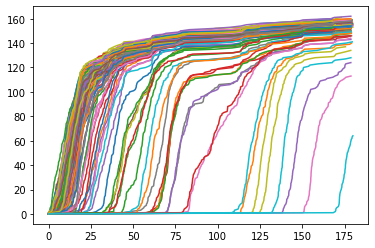

In [33]:
for a in range(140):
    plt.plot(np.array(prop_tree_tw[a][1])/(6*60), range(len(prop_tree_tw[a][1])))
# prop_tree_dict = {a:[[],[],[],[]] for a in range(N_ants)}
# prop_tree_dict = [[[],[],[],[]] for a in N_ants]
# prop_tree_dict[0][0] = prop_tree[0][1]
# prop_tree_dict

# with open('data/propagation_trees_data.pkl', 'rb') as f:
#     prop_tree = pickle.load(f)
# prop_tree


# Connectivity Dataframe (Gcc_df)

In [ ]:
# Time vs Connectivity

def compute_Gcc(exp, start, end):
    
    # Number of ants
    N_ants = len(exp.Ants)    

    # initialise adj-matrix
    adj_mat = np.zeros((N_ants, N_ants))
    
    Gcc = [[sorted(nx.connected_components(nx.Graph(adj_mat)), key=len, reverse=True)],
           [0]]

    # Populate network
    for i in fm.Query.ComputeAntInteractions(exp,start=start,end=end,maximumGap=fm.Duration(max_gap*10**9),
                                            reportFullTrajectories= False)[1]:
        # Focus on Nest zone (id=1)
        if (1 in i.Trajectories[1].Zones) & (adj_mat[i.IDs[0]-1, i.IDs[1]-1] == 0):
            
            adj_mat[i.IDs[0]-1, i.IDs[1]-1] = 1           
         
            if i.Start.After(start.Add(fm.Duration((Gcc[1][-1] + 1) * 10**9))):
    
                Gcc[0].append(sorted(nx.connected_components(nx.Graph(adj_mat)), key=len, reverse=True))
                Gcc[1].append(Gcc[1][-1] + 1)
                    
    # network build
    return   Gcc



## ============= LOOP =============== 

Gcc_df = pd.DataFrame(columns=['rep', 'exp', 'Gcc'])
max_gap = 10
for myrm_file in myrm_list[20:]:

    if int(myrm_file[8:10])==41: 
        continue

    print(myrm_file)

    # Open experiment file
    exp = fm.Experiment.Open(working_dir + myrm_file)

    ## ------ Time window ------ 
    start_date = (fm.Time.ToDateTime(fm.Query.GetDataInformations(exp).End) +
                 timedelta(days = -1)).strftime("%Y-%m-%d")

    start_time = fm.Time(datetime.fromisoformat(start_date + 'T09:00:00'))  
    
    Gcc = compute_Gcc(exp,start_time,start_time.Add(fm.Duration(12 * 60 * 60 * 10**9)))
    
    Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)

    
# Save
a_file = open("data/Gcc_NEST.pkl", "wb")
pickle.dump(Gcc_df, a_file)
a_file.close()


EG_NTM_s13_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s13_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s14_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s14_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s15_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s15_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s16_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s16_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s17_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s17_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s18_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s18_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s19_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s19_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s20_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s20_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s21_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s21_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s22_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s22_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s23_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s23_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s24_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s24_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s25_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s25_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s26_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s26_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s27_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s27_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s28_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s28_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s29_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s29_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s30_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s30_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s31_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s31_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s32_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s32_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s33_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s33_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s34_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s34_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s35_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s35_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s36_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s36_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s37_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s37_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s38_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s38_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s39_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s39_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s40_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s40_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s42_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s42_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s43_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s43_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s44_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s44_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s45_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s45_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s46_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s46_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s47_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s47_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s48_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s48_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s49_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s49_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s50_DIAa.myrmidon
